In [4]:
import torch
import torch.optim as optim
from torch.nn import Module, Sequential, Linear, LeakyReLU, BCEWithLogitsLoss
from dpm.train import train
from dpm.visualize import plot_model, plot_models, plot_stats, plot_hist, plot_hists
from dpm.distributions import *
from dpm.mixture_models import MixtureModel, GumbelMixtureModel
from pprint import pprint
from dpm.divergences import forward_kl, reverse_kl

In [199]:
class FDivergence(Module):
    def __init__(self):
        super().__init__()
        
    def div_function(self, ratio):
        raise NotImplementedError()
        
    def forward(self, p_model, q_model, batch_size=64):
        q_samples = q_model.sample(batch_size)
        prob = (p_model.log_prob(q_samples) \
                - q_model.log_prob(q_samples)).exp()
        return self.div_function(prob).mean()
    
class ForwardKLFDiv(FDivergence):
    def __init__(self, n_dims):
        super(KL, self).__init__()
    
    def div_function(self, ratio):
        return ratio * torch.log(ratio)

class ReverseKLFDiv(FDivergence):
    def __init__(self, n_dims):
        super().__init__()
    
    def div_function(self, ratio):
        return - torch.log(ratio)


class TotalVariationFDiv(FDivergence):
    def __init__(self, n_dims):
        super().__init__()
    
    def div_function(self, ratio):
        return 0.5 * torch.abs(ratio - 1.0)
    
class TotalVariation(Module):
    def __init__(self, n_dims):
        super().__init__()
        
    def forward(self, p_model, q_model, batch_size=64):
        q_samples = q_model.sample(batch_size)
        values = torch.abs(p_model.log_prob(q_samples).exp() \
                           - q_model.log_prob(q_samples).exp())
        values /= q_model.log_prob(q_samples).exp()
        return values.mean()
    


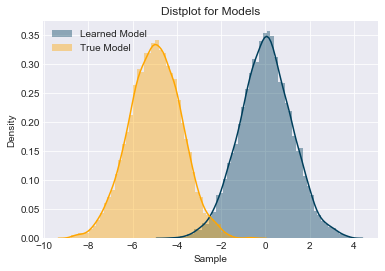

In [203]:
# p_model = MixtureModel([Normal([2.5], [[3.0]]), Normal([-2.5], [[3.0]])], [0.5,0.5])
# q_model = GumbelMixtureModel([Normal([0.0], [[1.0]]), Normal([0.0], [[1.0]])], [0.5,0.5])
p_model = Normal([-5.0], [[1.4]])
q_model = Normal([0.0], [[1.4]])
plot_models(p_model, q_model)

In [204]:
stats = train(p_model, q_model, TotalVariation, 
              batch_size=64, epochs=4000)

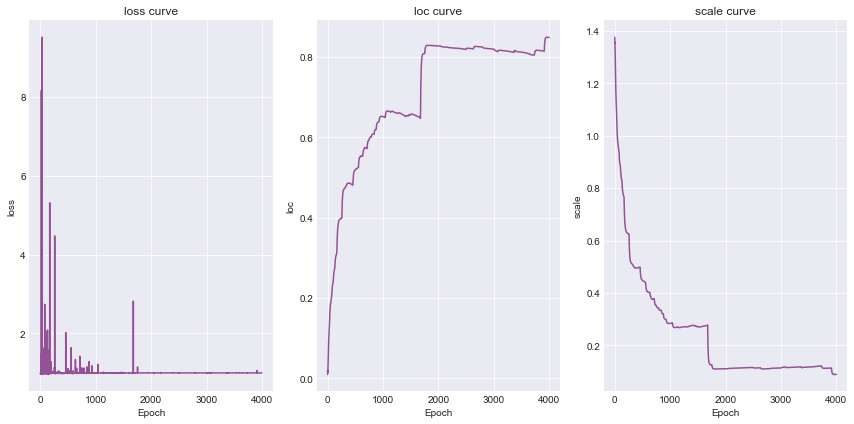

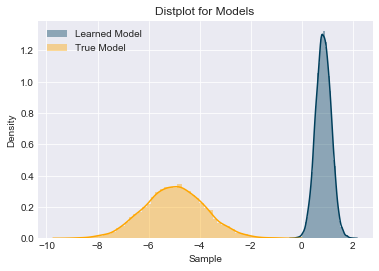

In [205]:
plot_stats(stats)
plot_models(p_model, q_model)

In [206]:
pprint(q_model.get_parameters())
pprint(p_model.get_parameters())

{'loc': 0.8485090732574463, 'scale': 0.08870328962802887}
{'loc': -5.0, 'scale': 1.4000000953674316}


In [132]:
# stats.data

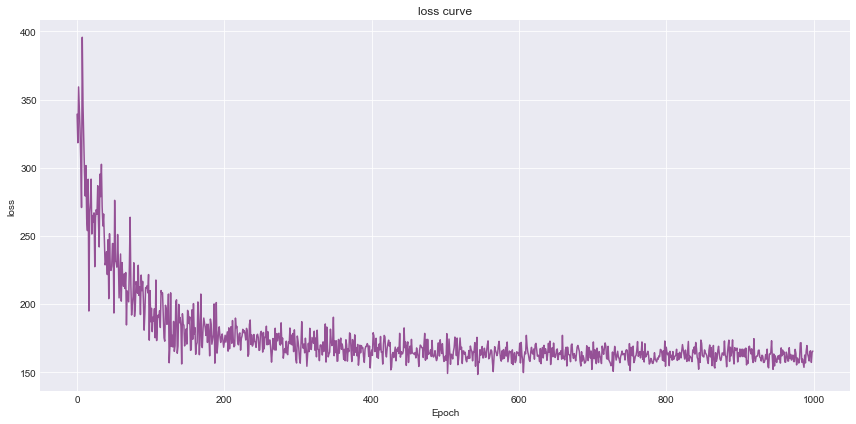

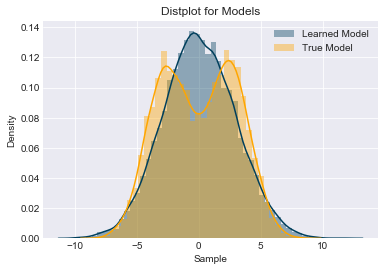

In [127]:
p_model = MixtureModel([Normal([2.5], [[3.0]]), Normal([-2.5], [[3.0]])], [0.5,0.5])
q_model = GumbelMixtureModel([Normal([0.0], [[1.0]]), Normal([0.0], [[1.0]])], [0.5,0.5])
# plot_models(p_model, q_model)
stats = train(p_model, q_model, forward_kl)
plot_stats(stats)
plot_models(p_model, q_model)

In [46]:
q_model.categorical.probs

tensor([0.5000, 0.5000], grad_fn=<SoftmaxBackward>)